Download weights folder from here using this link: [weights](https://drive.google.com/file/d/1dZm-AzKsIqAEMmvGiurAQzUwwFhAyzuz/view?usp=sharing)

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [2]:
%cd "drive/My Drive/Face-Verification"

/content/drive/My Drive/Face-Verification


In [3]:
# from tensorflow import keras
%tensorflow_version 1.x
from keras.models import Sequential
from keras.layers import Conv2D, ZeroPadding2D, Activation, Input, concatenate
from keras.models import Model
from keras.layers.normalization import BatchNormalization
from keras.layers.pooling import MaxPooling2D, AveragePooling2D
from keras.layers.merge import Concatenate
from keras.layers.core import Lambda, Flatten, Dense
from keras.initializers import glorot_uniform
from keras.engine.topology import Layer
from keras import backend as K
K.set_image_data_format('channels_first')
import cv2
import os
import numpy as np
from numpy import genfromtxt
import pandas as pd
import tensorflow as tf
from fr_utils import *
from inception_blocks_v2 import *
import imutils
import pickle


%matplotlib inline
%load_ext autoreload
%autoreload 2

# np.set_printoptions(threshold=np.nan)

TensorFlow 1.x selected.


Using TensorFlow backend.


In [4]:
FRmodel = faceRecoModel(input_shape=(3, 96, 96))

Instructions for updating:
If using Keras pass *_constraint arguments to layers.




In [5]:
def triplet_loss(y_true, y_pred, alpha = 0.2):
    
    anchor, positive, negative = y_pred[0], y_pred[1], y_pred[2]

    pos_dist = tf.reduce_sum(tf.square(tf.subtract(anchor, positive)), axis = -1)
    neg_dist = tf.reduce_sum(tf.square(tf.subtract(anchor, negative)), axis = -1)
    basic_loss = (pos_dist - neg_dist) + alpha
    loss = tf.reduce_sum(tf.maximum(basic_loss, 0.0))
    
    return loss

In [6]:
FRmodel.compile(optimizer = 'adam', loss = triplet_loss, metrics = ['accuracy'])
load_weights_from_FaceNet(FRmodel)

In [7]:
face_detector_path = 'opencv-face-recognition/face_detection_model/'
protoPath = os.path.sep.join([face_detector_path, "deploy.prototxt"])
modelPath = os.path.sep.join([face_detector_path,
	"res10_300x300_ssd_iter_140000.caffemodel"])
detector = cv2.dnn.readNetFromCaffe(protoPath, modelPath)
confidence_threshold = 0.95 

def get_Face(image_path):
  image = cv2.imread(image_path)
  image = imutils.resize(image, width=600)
  (h, w) = image.shape[:2]

  # construct a blob from the image
  imageBlob = cv2.dnn.blobFromImage(
    cv2.resize(image, (300, 300)), 1.0, (300, 300),
    (104.0, 177.0, 123.0), swapRB=False, crop=False)

  detector.setInput(imageBlob)
  detections = detector.forward()

  # face_count = 0
  max_conf_so_far = 0.0
  face = None
  d = None
  # loop over the detections
  for i in range(0, detections.shape[2]):
    confidence = detections[0, 0, i, 2]

    # filter out weak detections
    if confidence > confidence_threshold and confidence>max_conf_so_far:
      box = detections[0, 0, i, 3:7] * np.array([w, h, w, h])
      (startX, startY, endX, endY) = box.astype("int")

      face = image[startY:endY, startX:endX]
      (fH, fW) = face.shape[:2]

      if fW < 100 or fH < 100:
        print("Detected face size too small w.r.t Image")
        continue

      max_conf_so_far = confidence
      # face_count += 1

      d = {'conf': confidence, 
           'H' : fH,
           'W' : fW}
  
  print("Confidence of the face detected: ", max_conf_so_far)
  return face, d

In [8]:
def plot_images(images):
  plt.figure(figsize=(20,10))
  columns = 5
  for i, image in enumerate(images):
      plt.subplot(len(images) / columns + 1, columns, i + 1)
      plt.imshow(image)

In [9]:
def match(img1, img2, model=FRmodel):
    encoding = get_img_encoding(img1, model)
    encoding2= get_img_encoding(img2, model)
    
    dist = np.linalg.norm(encoding - encoding2)
    
    if dist < 0.7:
        print("Ok Matching!")
        is_match = True
    else:
        print("Not Matching")
        is_match = False
        
    return dist, is_match

In [12]:
def face_verification(img_pth1, img_pth2):
  face1, data1 = get_Face(img_pth1)
  face2, data2 = get_Face(img_pth2)

  if(data1 == None):
    print("Face not detected for Image-1")
    return
  if(data2 == None):
    print("Face not detected for Image-2")
    return

  print(data1)
  print(data2)

  val = match(face1, face2)
  print(val)
  face1 = cv2.cvtColor(face1, cv2.COLOR_BGR2RGB)
  face2 = cv2.cvtColor(face2, cv2.COLOR_BGR2RGB)

  ##--Experimenting with Grayscale image--
  gray1 = cv2.cvtColor(face1, cv2.COLOR_BGR2GRAY)
  gray2 = cv2.cvtColor(face2, cv2.COLOR_BGR2GRAY)

  arr = np.array(gray1)
  temp1 = np.stack((arr, arr, arr), axis=2)
  arr = np.array(gray2)
  temp2 = np.stack((arr, arr, arr), axis=2)

  val = match(temp1, temp2)
  print(val)

  plot_images([face1, face2, temp1, temp2])
  # plot_images([face1, face2])


Confidence of the face detected:  0.9999912
Confidence of the face detected:  0.9999933
{'conf': 0.9999912, 'H': 198, 'W': 129}
{'conf': 0.9999933, 'H': 350, 'W': 243}
Ok Matching!
(0.6641934, True)
Not Matching
(0.8178399, False)


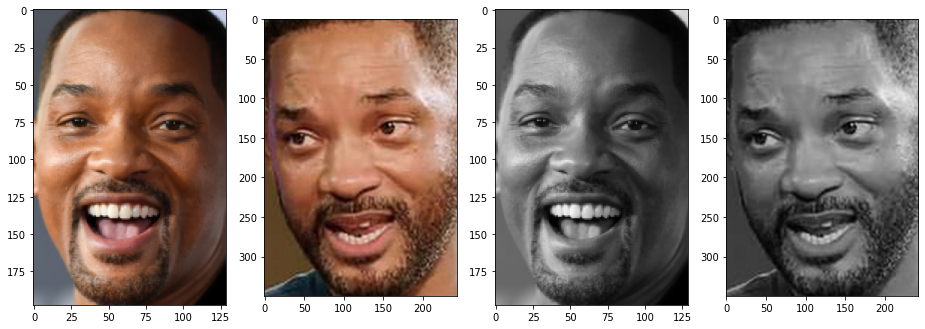

In [14]:
img1 = "images/ws2.jpg"
img2 = "images/ws1.jpg"
face_verification(img1, img2)

###Not matching when face has a tilt with an angled pose

Confidence of the face detected:  0.9999912
Confidence of the face detected:  0.99849224
{'conf': 0.9999912, 'H': 198, 'W': 129}
{'conf': 0.99849224, 'H': 401, 'W': 304}
Not Matching
(0.9982402, False)
Not Matching
(1.1495578, False)


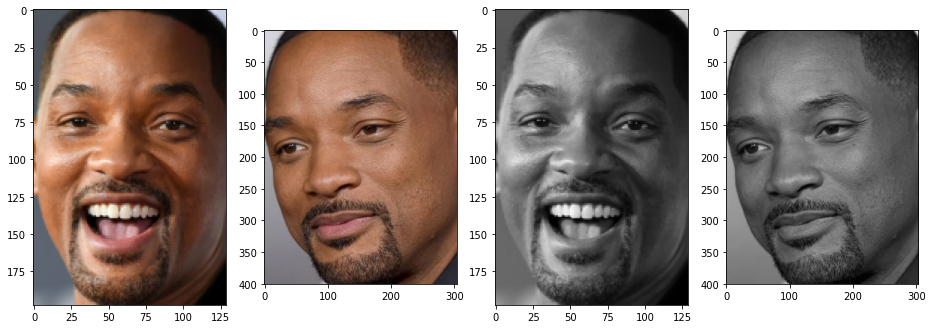

In [14]:
img1 = "images/ws2.jpg"
img2 = "images/ws3.jpg"
face_verification(img1, img2)

Confidence of the face detected:  0.9999726
Confidence of the face detected:  0.9999856
{'conf': 0.9999726, 'H': 400, 'W': 282}
{'conf': 0.9999856, 'H': 466, 'W': 293}
Ok Matching!
(0.6733789, True)
Ok Matching!
(0.6850419, True)


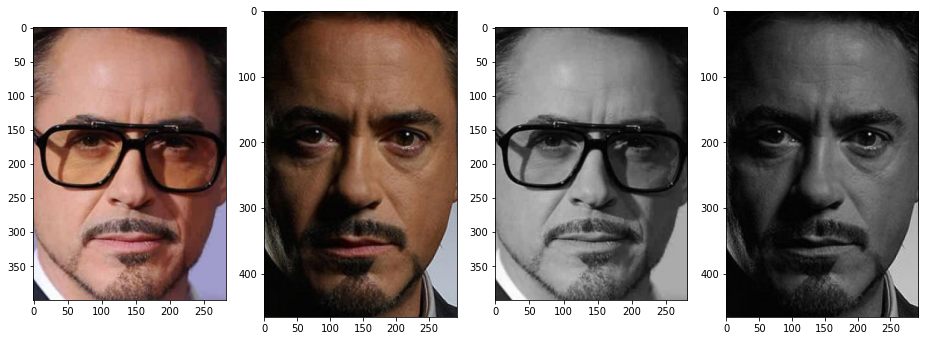

In [19]:
img1 = "images/tony.jpg"
img2 = "images/tony5.jpg"
face_verification(img1, img2)

###Expressions and eye shades may hinder the performance

Confidence of the face detected:  0.9999726
Confidence of the face detected:  0.9881147
{'conf': 0.9999726, 'H': 400, 'W': 282}
{'conf': 0.9881147, 'H': 167, 'W': 125}
Not Matching
(0.7141757, False)
Not Matching
(0.72207874, False)


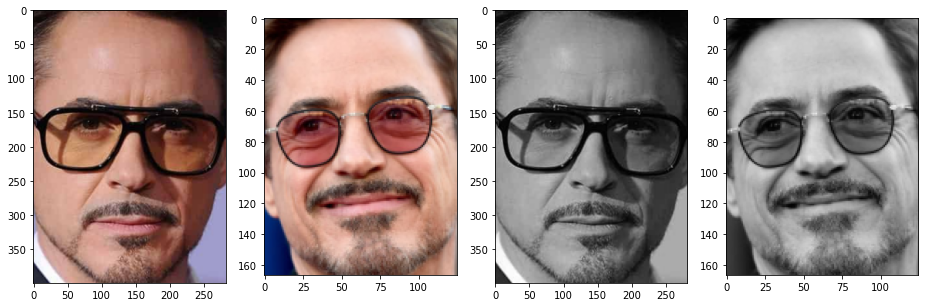

In [18]:
img1 = "images/tony.jpg"
img2 = "images/tony3.jpg"
face_verification(img1, img2)

Confidence of the face detected:  0.99803907
Confidence of the face detected:  0.9999726
{'conf': 0.99803907, 'H': 250, 'W': 175}
{'conf': 0.9999726, 'H': 400, 'W': 282}
Ok Matching!
(0.6435265, True)
Not Matching
(0.7803504, False)


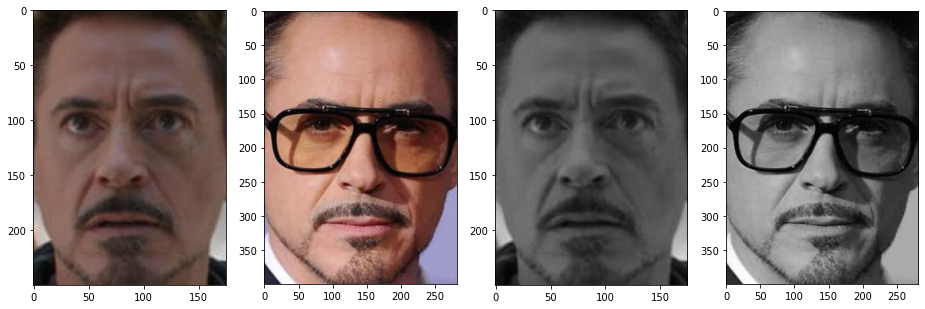

In [20]:
img1 = "images/tony4.jpg"
img2 = "images/tony.jpg"
face_verification(img1, img2)

In [21]:
## Experiment on large size input blob for embeddings. Currently 96x96 only